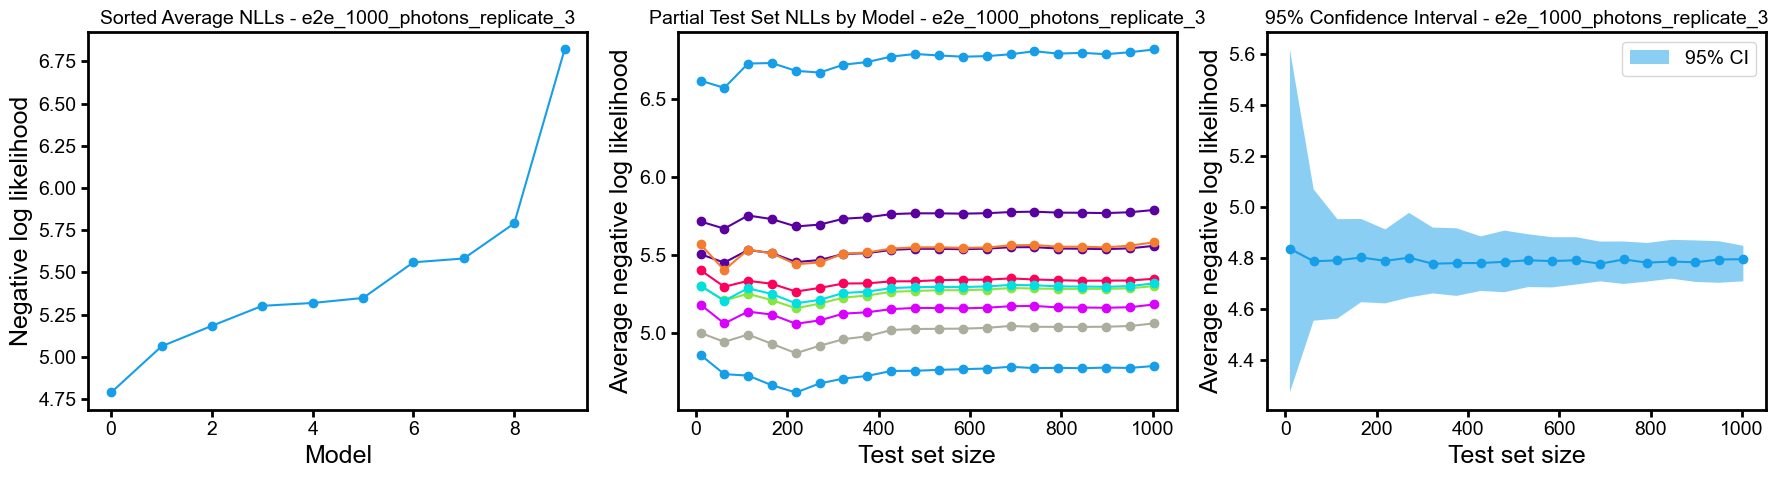

Results for e2e_1000_photons_replicate_3:
Mutual information: 2.3960 bits
Lower bound: 2.2814 bits
Upper bound: 2.5124 bits
Confidence interval: 0.2310 bits




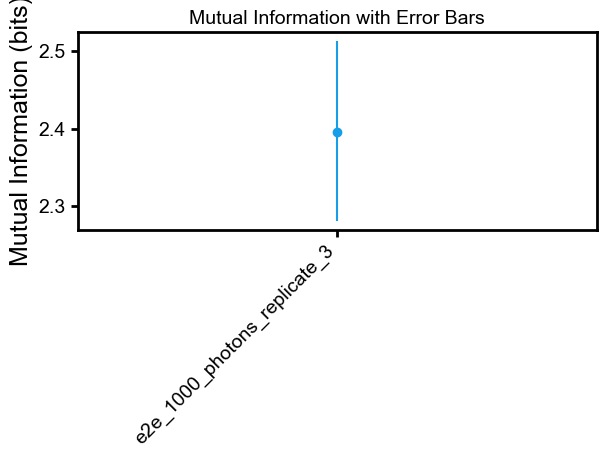

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from cleanplots import *
import glob


# List of results files
results_files = glob.glob('/home/emarkley/Workspace/PYTHON/EncodingInformation/color_filter_array/mi_results/*.npz')
# remove any file containing 'lcfa'
results_files = [file for file in results_files if 'lcfa' not in file]
results_files = results_files[::-1]

# List to hold data from each results file
results_list = []

# Labels for the results files
labels = []

for file in results_files:
    # Load results from file
    results = np.load(file)
    data = {}
    data['average_nlls'] = results['average_nlls']
    data['partial_test_set_nlls_by_model'] = results['partial_test_set_nlls_by_model']
    data['test_set_sizes'] = results['test_set_sizes']
    data['mean_nll_dist_by_size'] = results['mean_nll_dist_by_size']
    data['mean_nll_dist_by_size_conf_low'] = results['mean_nll_dist_by_size_conf_low']
    data['mean_nll_dist_by_size_conf_high'] = results['mean_nll_dist_by_size_conf_high']
    data['mutual_information'] = results['mutual_information']
    data['mutual_information_conf_low'] = results['mutual_information_conf_low']
    data['mutual_information_conf_high'] = results['mutual_information_conf_high']
    data['filter_matrix'] = results['filter_matrix']
    results_list.append(data)
    
    # Extract label from filename
    label = file.split('/')[-1].replace('prerendered_', '').replace('.npz', '')
    labels.append(label)

# Lists to collect mutual information and error bars
mutual_informations = []
lower_bounds = []
upper_bounds = []

# Plotting for each results file
for idx, data in enumerate(results_list):
    label = labels[idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot sorted average NLLs
    axs[0].plot(np.sort(data['average_nlls']), '-o')
    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Negative log likelihood')
    axs[0].set_title(f'Sorted Average NLLs - {label}')

    # Plot test set size vs. partial NLLs
    for i, partial_nlls in enumerate(data['partial_test_set_nlls_by_model']):
        axs[1].plot(data['test_set_sizes'], partial_nlls, '-o', label=f'Model {i}')
    axs[1].set_xlabel('Test set size')
    axs[1].set_ylabel('Average negative log likelihood')
    axs[1].set_title(f'Partial Test Set NLLs by Model - {label}')

    # Plot the 95% confidence interval
    axs[2].plot(data['test_set_sizes'], np.median(data['mean_nll_dist_by_size'], axis=1), '-o')
    axs[2].fill_between(data['test_set_sizes'], data['mean_nll_dist_by_size_conf_low'], data['mean_nll_dist_by_size_conf_high'], alpha=0.5, label='95% CI')
    axs[2].set_xlabel('Test set size')
    axs[2].set_ylabel('Average negative log likelihood')
    axs[2].legend()
    axs[2].set_title(f'95% Confidence Interval - {label}')

    plt.tight_layout()
    plt.show()

    
    # Collect mutual information and error bounds
    mutual_informations.append(data['mutual_information'])
    lower_bounds.append(data['mutual_information_conf_low'])
    upper_bounds.append(data['mutual_information_conf_high'])
    
    # Print mutual information results
    print(f'Results for {label}:')
    print('Mutual information: {:.4f} bits'.format(data['mutual_information']))
    print('Lower bound: {:.4f} bits'.format(data['mutual_information_conf_low']))
    print('Upper bound: {:.4f} bits'.format(data['mutual_information_conf_high']))
    print('Confidence interval: {:.4f} bits'.format(data['mutual_information_conf_high'] - data['mutual_information_conf_low']))
    print('\n')

# Compute error bars
error_lower = [mi - lb for mi, lb in zip(mutual_informations, lower_bounds)]
error_upper = [ub - mi for mi, ub in zip(mutual_informations, upper_bounds)]

# Plot mutual information with error bars for all results files
x = np.arange(len(mutual_informations))

fig, ax = plt.subplots()
ax.errorbar(x, mutual_informations, yerr=[error_lower, error_upper], fmt='o')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Mutual Information (bits)')
ax.set_title('Mutual Information with Error Bars')
plt.tight_layout()
plt.show()


In [37]:
import pickle
import glob
import numpy as np
recon_result_files = glob.glob('/home/emarkley/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/*.pkl')

for file in recon_result_files:
    with open(file, 'rb') as f:
        result = pickle.load(f)

    mse_values = np.array(result['MSE'])
    ssim_values = np.array(result['SSIM'])
    psnr_values = np.array(result['PSNR'])
    #replace inf psnr values with 100
    psnr_values[np.isinf(psnr_values)] = 100
    # calculate the confidence interval of the mean by sampling with replacement
    def bootstrap_confidence_interval(data, num_samples=100, confidence_level=0.95):
        
        means = []
        n = len(data)
        for _ in range(num_samples):
            sample = np.random.choice(data, size=n, replace=True)
            means.append(np.mean(sample))
        lower_bound = np.percentile(means, (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(means, (1 + confidence_level) / 2 * 100)
        return np.mean(data), lower_bound, upper_bound

    num_samples = 100
    mse_mean, mse_lower, mse_upper = bootstrap_confidence_interval(mse_values, num_samples=num_samples)
    ssim_mean, ssim_lower, ssim_upper = bootstrap_confidence_interval(ssim_values, num_samples=num_samples)
    psnr_mean, psnr_lower, psnr_upper = bootstrap_confidence_interval(psnr_values, num_samples=num_samples)

    print(f"Results for {file}:")
    print(f"MSE: {mse_mean:.4f} (95% CI: {mse_lower:.4f} - {mse_upper:.4f})")
    print(f"SSIM: {ssim_mean:.4f} (95% CI: {ssim_lower:.4f} - {ssim_upper:.4f})")
    print(f"PSNR: {psnr_mean:.4f} (95% CI: {psnr_lower:.4f} - {psnr_upper:.4f})")





Results for /home/emarkley/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/lcfa_1000_photons_evaluation_results.pkl:
MSE: 0.0003 (95% CI: 0.0000 - 0.0006)
SSIM: 0.9656 (95% CI: 0.9584 - 0.9715)
PSNR: 48.9685 (95% CI: 47.5799 - 50.5429)
Results for /home/emarkley/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/e2e_1000_photons_high_gamma_fast_mask_evaluation_results.pkl:
MSE: 0.0003 (95% CI: 0.0000 - 0.0007)
SSIM: 0.9685 (95% CI: 0.9636 - 0.9737)
PSNR: 49.7500 (95% CI: 48.4698 - 51.3237)
Results for /home/emarkley/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/bayer_filter_1000_photons_evaluation_results.pkl:
MSE: 0.0004 (95% CI: 0.0000 - 0.0009)
SSIM: 0.9661 (95% CI: 0.9590 - 0.9722)
PSNR: 49.0254 (95% CI: 47.6701 - 50.3080)
Results for /home/emarkley/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/ideal_1000_photons_slow_mask_high_gamma_evaluation_results.pkl:
MSE: 0.0004 (95% CI: 0.0001 - 0.0009)

In [27]:
np.mean(psnr_values)

49.01898473890581